In [1]:
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
import pandas as pd
from obspy.taup import TauPyModel

np.set_printoptions(precision=4, suppress=True)
for module in [fn, rm, opt, plots]:
    importlib.reload(module)

#### SOURCE MECHANISM

Original params:  [ 90.  45. -90.]


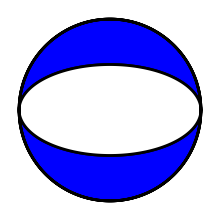

In [2]:
np.random.seed(2025)

# generate synthetic data
t, p = -fn.j_hat, fn.k_hat

# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# velocity model, assume depth, vp and vs cols
velocity_model = TauPyModel(model='ak135')
data_path = '../data/AK135_lookup.csv'
lookup_table = pd.read_csv(data_path)

# quake depth
hdepth = 15  # km - assumed quake depth

#### STATION LOCATION 1

Using sdr parameters.
Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 72%


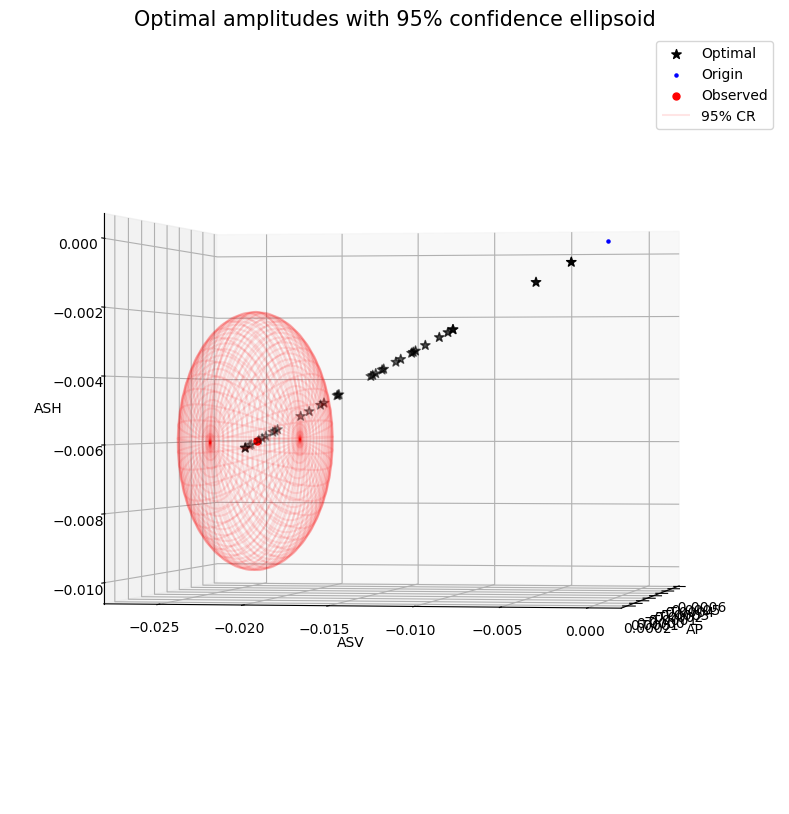

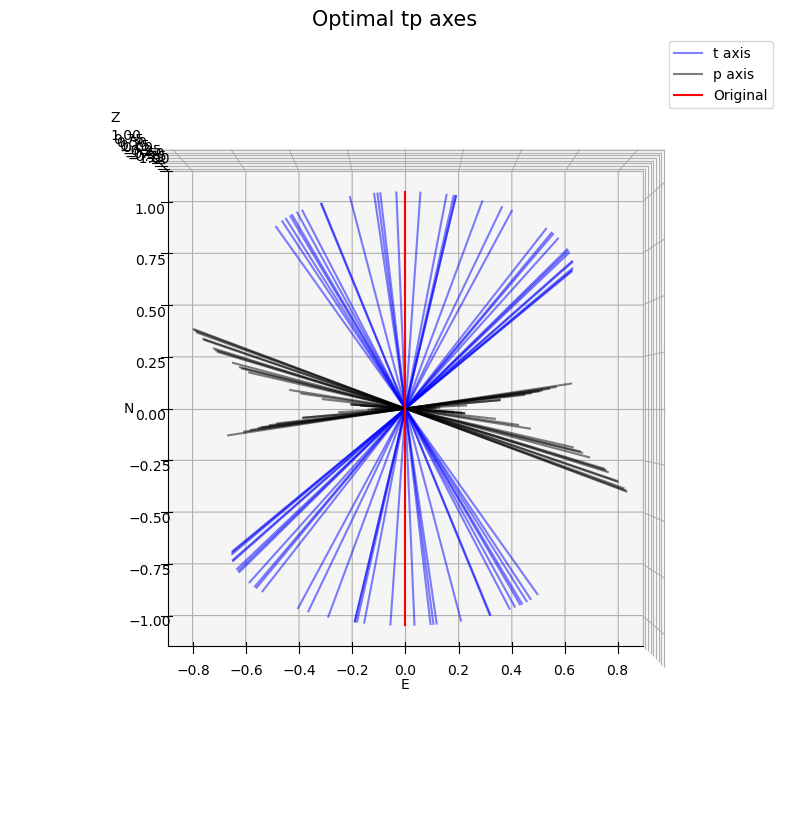

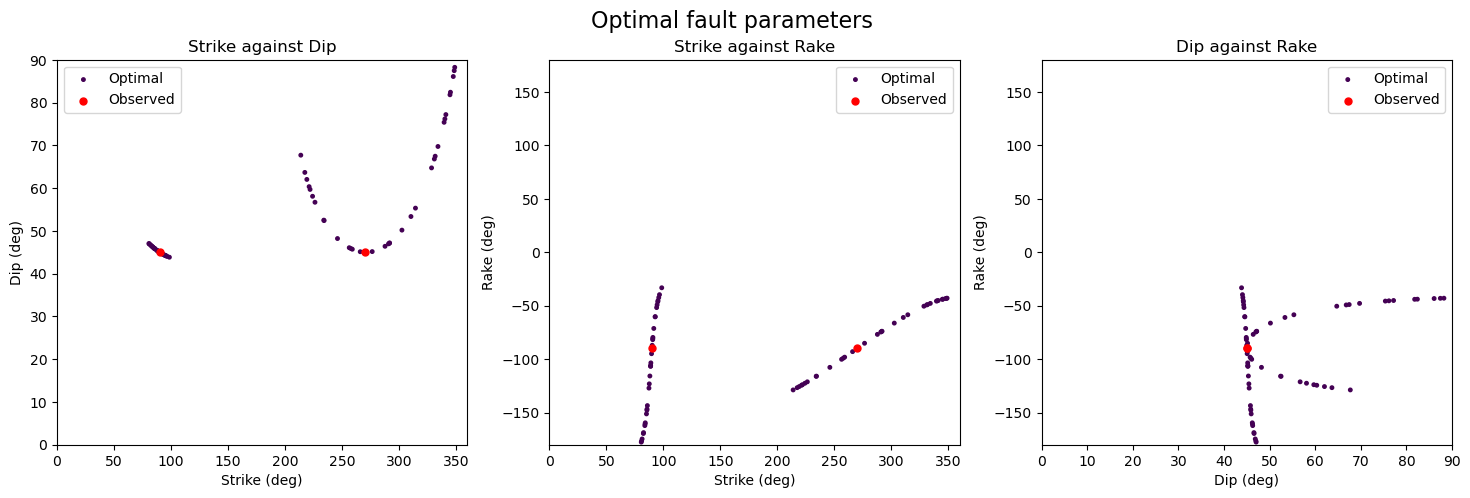

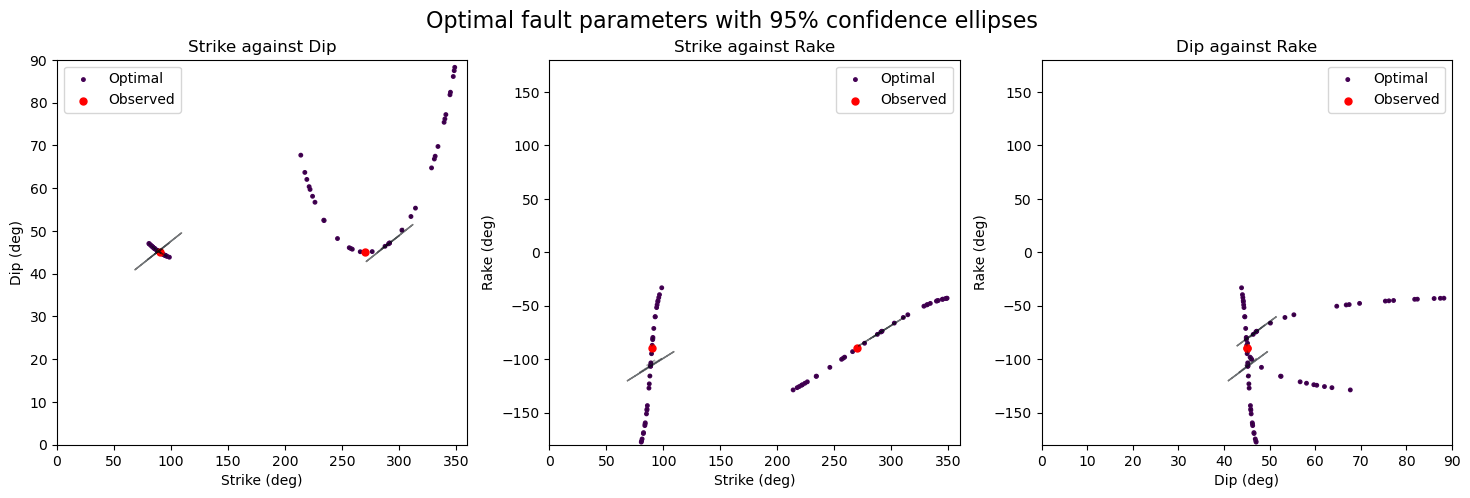

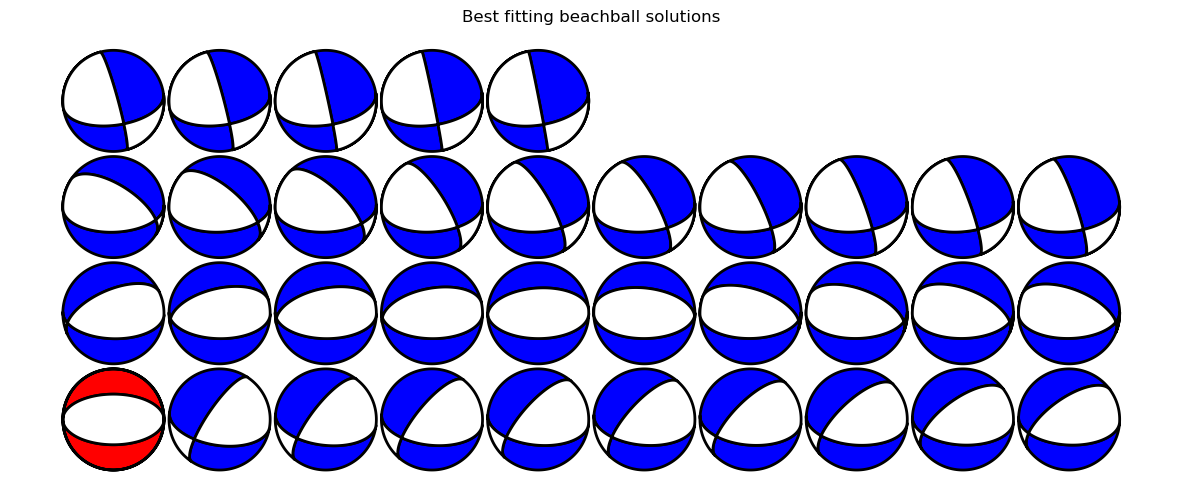

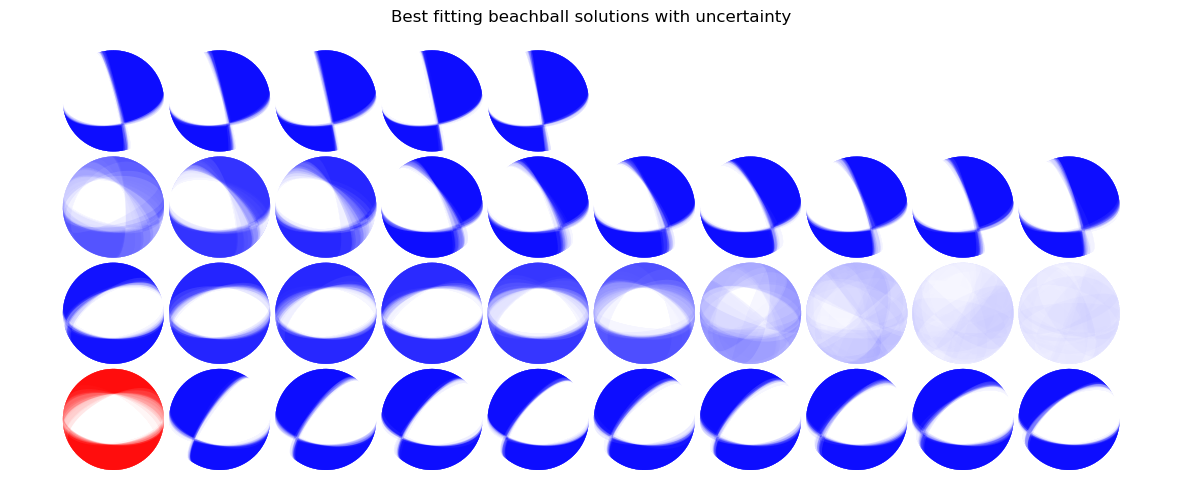

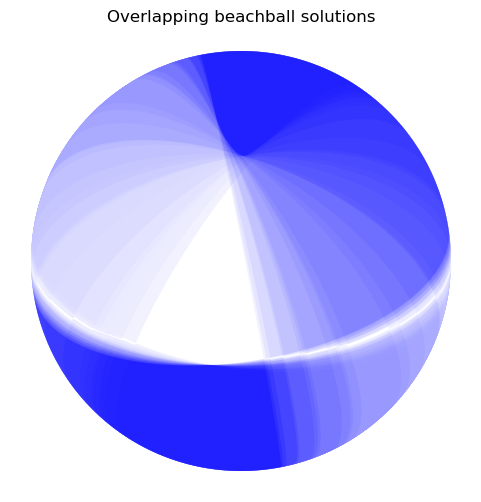

In [3]:
# set up hyperparameters for inversion
epdist_1 = 10  # degrees - epicentral distance
azimuth_1 = 200  # degrees - azimuth of seismometer

p_arrivals = velocity_model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist_1, phase_list=['P'])
s_arrivals = velocity_model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist_1, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
velocities = fn.extract_velocities(lookup_table, hdepth)

# initialize model
radiation_model_1 = rm.RadiationModel(np.deg2rad(azimuth_1), takeoff_angles, velocities)

model_Ao = radiation_model_1(np.deg2rad(true_params), set_Ao=True, return_A=True)

# tune hyperparameters for optimization
config = opt.get_config()
config['k_max'] = 4000

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

radiation_model_1.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model_1, config, start)

print(f'Convergence rate: {radiation_model_1.get_convergence_rate():.0f}%')
# amplitude plot
radiation_model_1.reset_grid_amplitudes()
radiation_model_1.set_grid_amplitudes(7, random=False, fix_params=False)
plots.amplitudes(radiation_model_1, azim=10, elev=0, s=50, alpha=0.5,
                 iterates=False, grid=False, cross_section=[0,0,0],
                 eps_factor=2e-2, optimal=True, observed=True, cmap='rainbow',
                    uncertainty=True, conf=0.95)

# tp axis plot
plots.tp_axes(radiation_model_1, azim=-90, elev=90, half=False)

# 2D iterates plot
plots.iterates_2D(radiation_model_1, s=25, optimal=True, index=2, cmap='viridis')
plots.iterates_2D(radiation_model_1, s=25, optimal=True, index=2, cmap='viridis',
                    uncertainty=True, conf=0.95)

# beachball plots
plots.beachballs(radiation_model_1, order_by='strike', width=10,  max_plot=50,
                 facecolor='blue', figsize=(15,10), overlap=False, original=True)
plots.beachballs(radiation_model_1, order_by='strike', width=10,  max_plot=50,
                 original=True, figsize=(15,10), overlap=False, uncertainty=True)

# overlapping beachball plot
plots.beachballs(radiation_model_1, order_by='strike', width=10,  max_plot=50,
                 facecolor='blue', figsize=(6,6), overlap=True, original=True)

#### STATION LOCATION 2

Using sdr parameters.
Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 98%


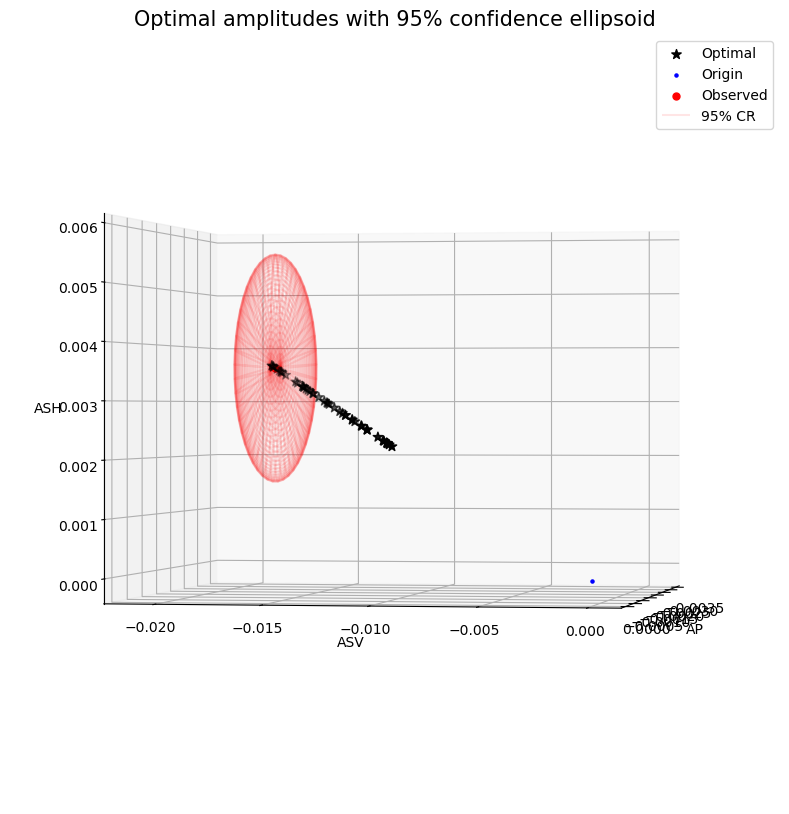

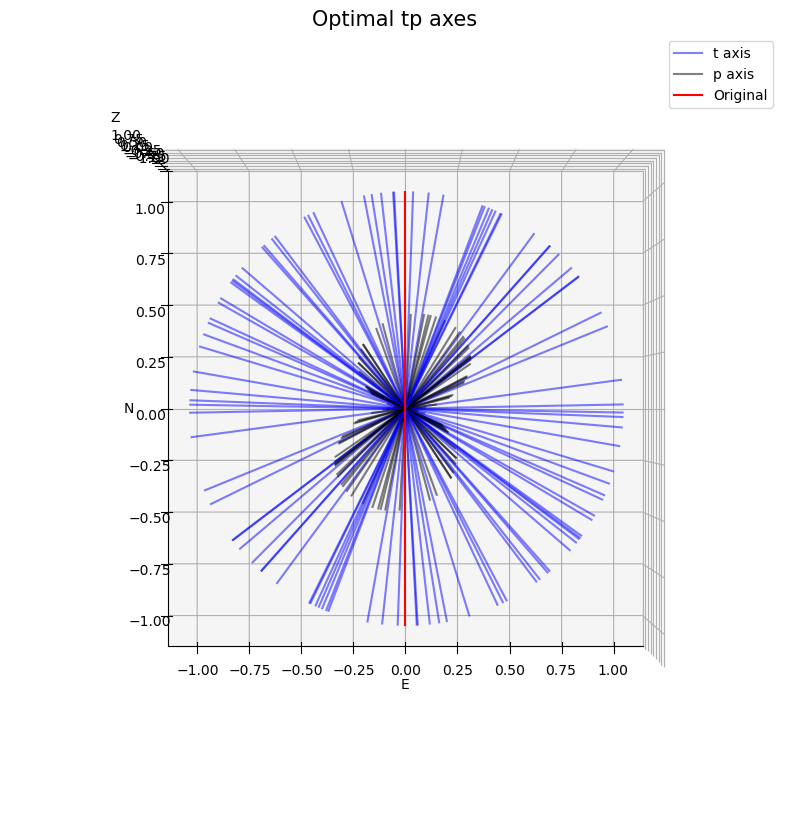

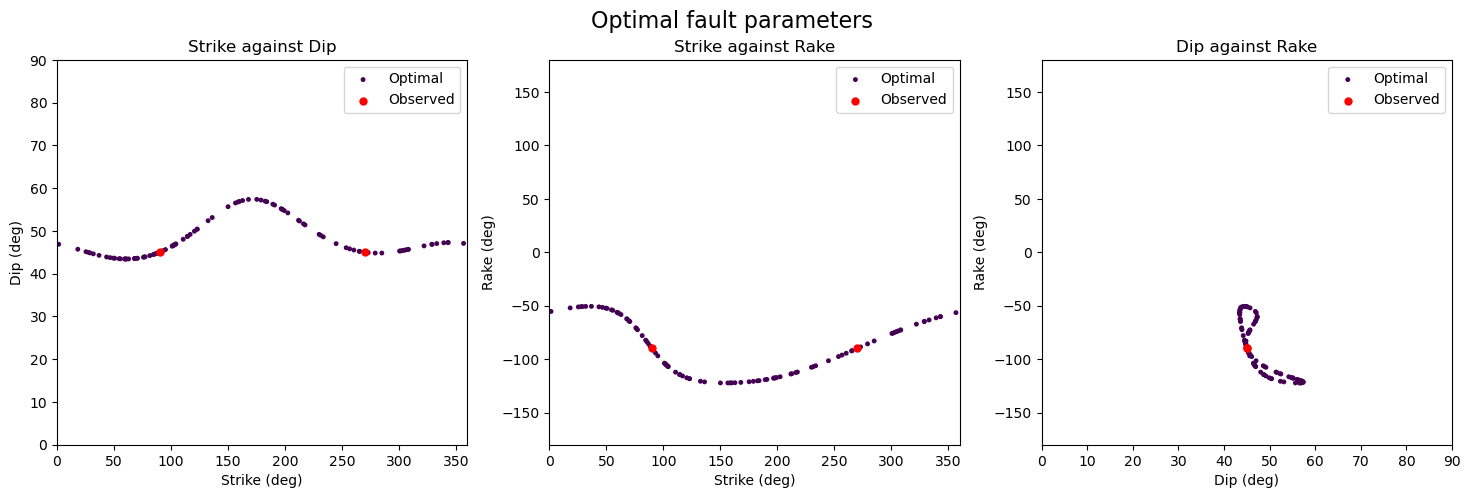

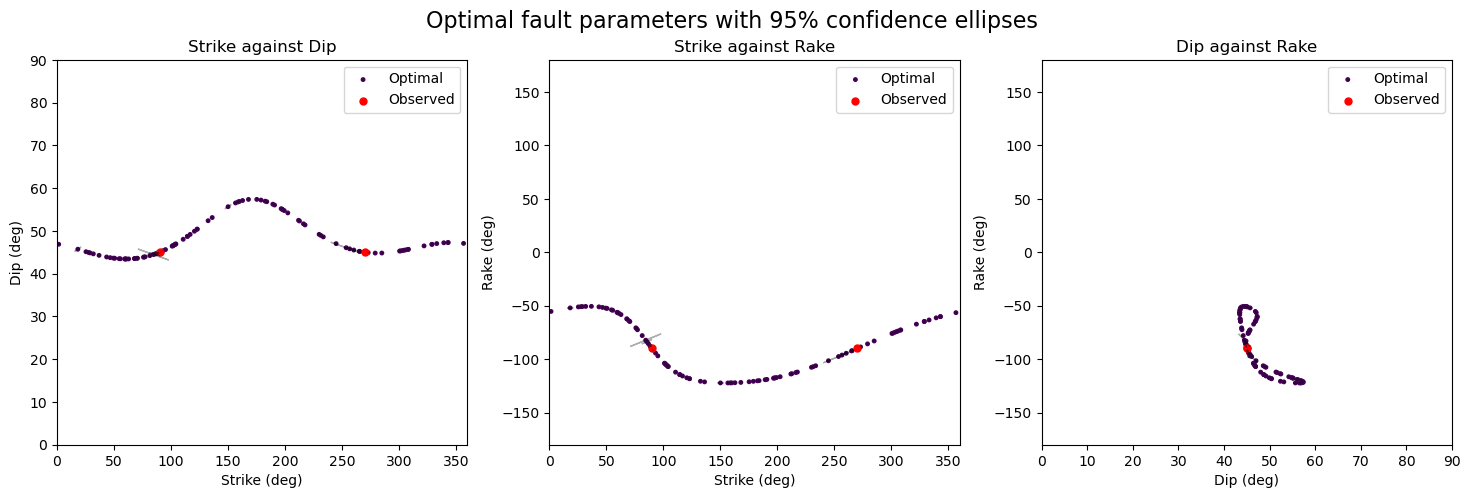

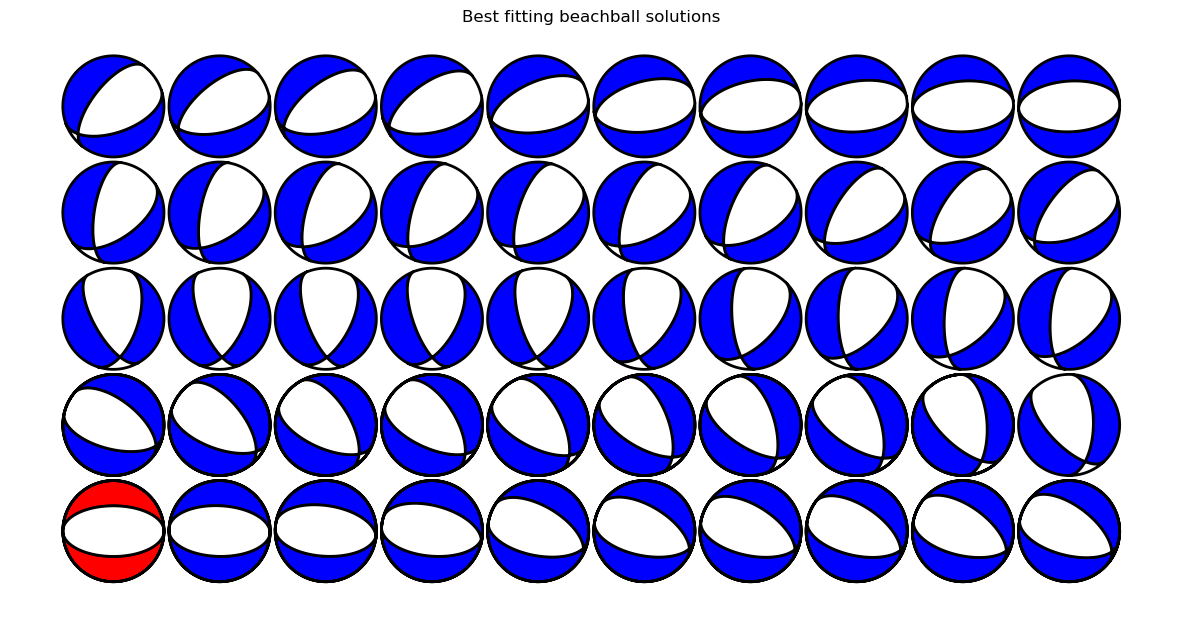

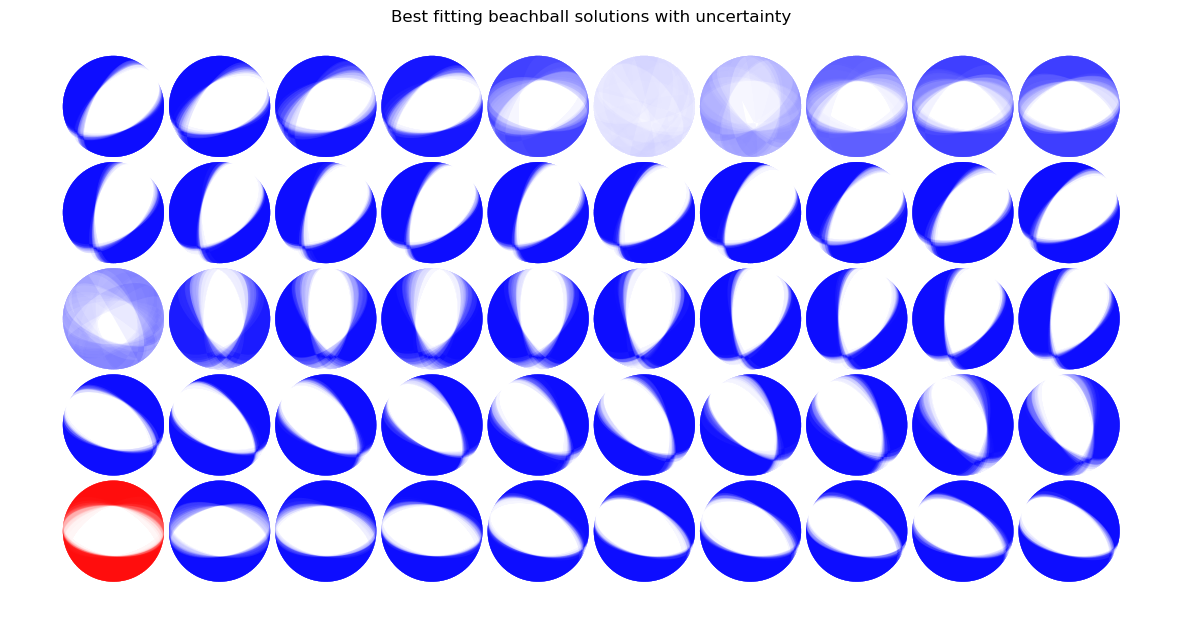

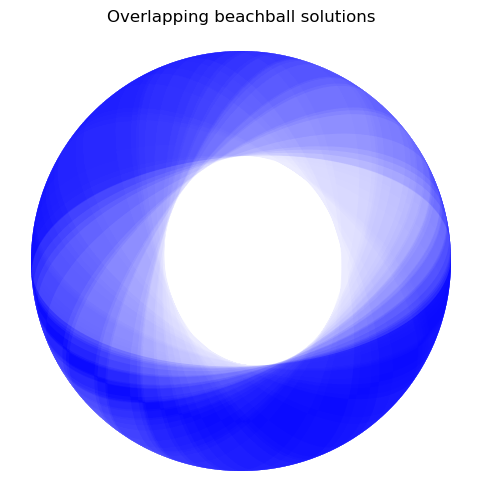

In [4]:
# set up hyperparameters for inversion
epdist_2 = 40  # degrees - epicentral distance
azimuth_2 = 160  # degrees - azimuth of seismometer

p_arrivals = velocity_model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist_2, phase_list=['P'])
s_arrivals = velocity_model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist_2, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
velocities = fn.extract_velocities(lookup_table, hdepth)

# initialize model
radiation_model_2 = rm.RadiationModel(np.deg2rad(azimuth_2), takeoff_angles, velocities)

model_Ao = radiation_model_2(np.deg2rad(true_params), set_Ao=True, return_A=True)

# tune hyperparameters for optimization
config = opt.get_config()
config['k_max'] = 4000

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

radiation_model_2.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model_2, config, start)

print(f'Convergence rate: {radiation_model_2.get_convergence_rate():.0f}%')
# amplitude plot
radiation_model_2.reset_grid_amplitudes()
radiation_model_2.set_grid_amplitudes(7, random=False, fix_params=False)
plots.amplitudes(radiation_model_2, azim=10, elev=0, s=50, alpha=0.5,
                 iterates=False, grid=False, cross_section=[0,0,0],
                 eps_factor=2e-2, optimal=True, observed=True, cmap='rainbow',
                    uncertainty=True, conf=0.95)

# tp axis plot
plots.tp_axes(radiation_model_2, azim=-90, elev=90, half=False)

# 2D iterates plot
plots.iterates_2D(radiation_model_2, s=25, optimal=True, index=2, cmap='viridis')
plots.iterates_2D(radiation_model_2, s=25, optimal=True, index=2, cmap='viridis',
                    uncertainty=True, conf=0.95)

# beachball plots
plots.beachballs(radiation_model_2, order_by='strike', width=10,  max_plot=50,
                 facecolor='blue', figsize=(15,10), overlap=False, original=True)
plots.beachballs(radiation_model_2, order_by='strike', width=10,  max_plot=50,
                 original=True, figsize=(15,10), overlap=False, uncertainty=True)

# overlapping beachball plot
plots.beachballs(radiation_model_2, order_by='strike', width=10,  max_plot=50,
                 facecolor='blue', figsize=(6,6), overlap=True, original=True)